In [2]:
from pyproj import CRS
from pyproj import Transformer
import numpy as np
import json
import pyproj
import matplotlib.pyplot as plt

In [3]:
import rasterio
from rasterio.windows import Window
from rasterio.plot import show



In [4]:
#Settings
in_file_name = 'eu_dem_v11_E40N20.TIF'
peak_data = 'Peaks.json'
out_file_name = 'eu_dem_v11_E40N20_peaks.TIF'

In [4]:
# read file
with open(peak_data, encoding="utf8") as myfile:
    data=myfile.read()
    
# parse file
data_dict = json.loads(data)

coordinates = []
# show values
for i in range(0,len(data_dict["features"])):  
     coordinates.append(data_dict["features"][i]["geometry"]["coordinates"])
        


In [10]:
#Coordinate System of OSM
crs_osm = CRS.from_epsg(4326)

#coordinate System of copernicus 
with rasterio.open(in_file_name) as src:
    #Export Coordinate System to pyprj
    print(src.crs)
    crs_eu = CRS.from_wkt(src.crs.wkt)
    eu_to_pos = src.transform.__invert__()
    shape = np.array(src.shape)
    index = src.index
#crs_eu = CRS.from_epsg(3035)
#make transformer from osm  to eu
osm_to_eu = Transformer.from_crs(crs_osm, crs_eu)



PROJCS["ETRS89_ETRS_LAEA",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4258"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",52],PARAMETER["longitude_of_center",10],PARAMETER["false_easting",4321000],PARAMETER["false_northing",3210000],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


In [11]:
#make ground Truth array
peaks = np.zeros(shape, dtype=bool)
positions = []
c = 0
print(len(coordinates))
for (y,x) in coordinates:
    #transfrom coordinates
    eu = osm_to_eu.transform(x,y)
    pos = np.array(eu_to_pos * eu)
    
    #pos = index(x,y)
    #print(pos)
    positions.append(pos)
    #Round to the next possible coordinate and set that to 1
    intpos = np.array((pos[0], pos[1]), dtype=np.uint16)
    #Because extracted area apparently is larger than expected
    if np.all(np.logical_and(intpos>0, intpos < 40000)):
        peaks[intpos[0]][intpos[1]] = 1
        c+=1
peaks = peaks.T
print("counter:", c)

98418
counter: 94103


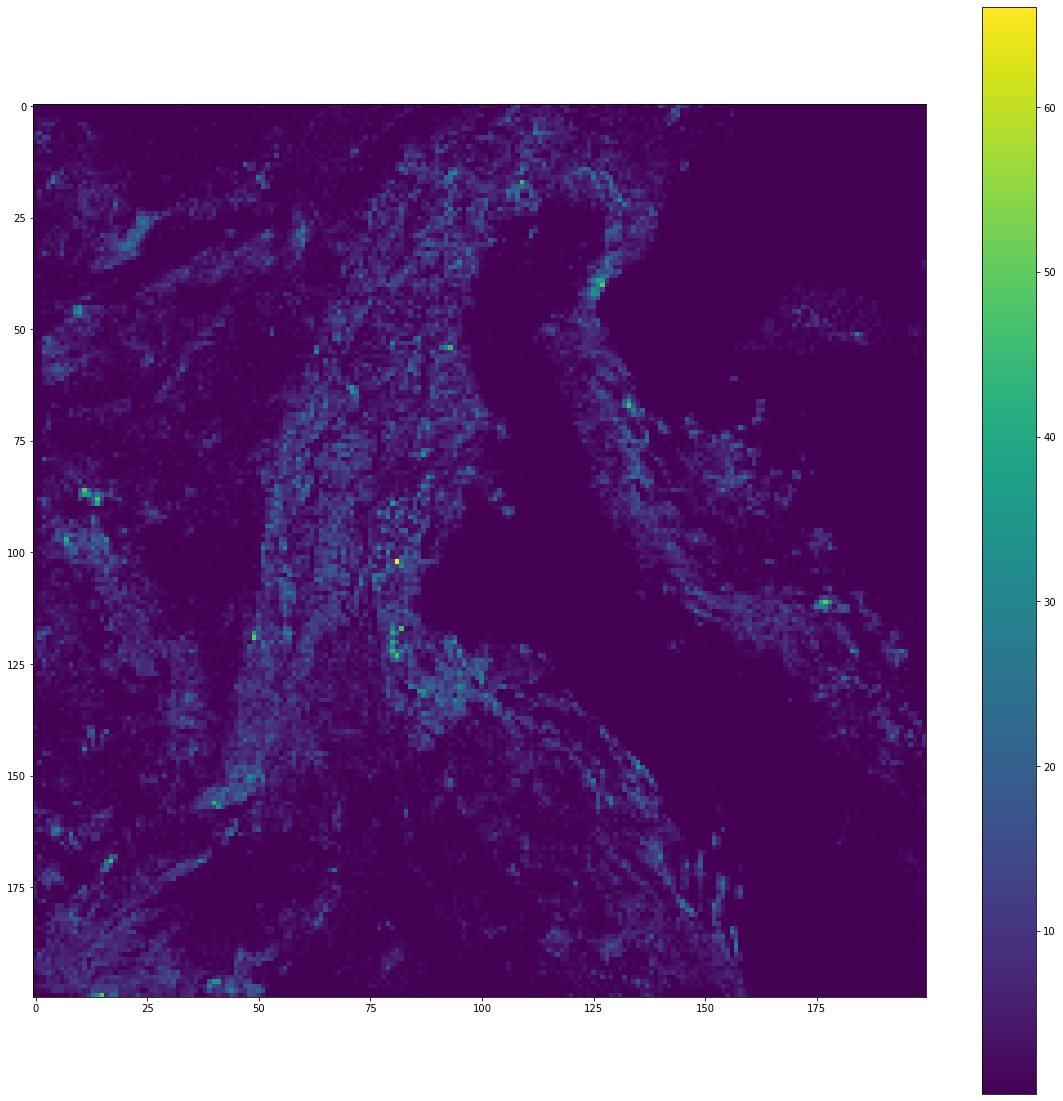

In [7]:
from matplotlib.colors import LogNorm

#Visualize Peaks
plt.figure(figsize=(20,20))
def downscale(image, factor, shape = None):
    
    try:
        n_stepX = shape[0]/factor
        n_stepY = shape[1]/factor
    except:
        shape = image.shape
        n_stepX = shape[0]/factor
        n_stepY = shape[1]/factor

    
    step = 1/factor
    newImage = np.zeros((int(shape[0]/factor), int(shape[1]/factor)))
    for index in np.ndindex(newImage.shape):
        newImage[index] = np.sum((image[index[0]*factor: (index[0]+1)*factor, index[1]*factor: (index[1]+1)*factor]))+0.1
    return newImage
np.flip(np.rot90(peaks, k=3), axis=1)
plt.imshow(downscale(peaks, 200))
plt.colorbar()
plt.savefig('peak_distribution.png', dpi=300)

In [12]:
# Save image
with rasterio.Env():
    
    with rasterio.open(in_file_name) as src:
        profile = src.profile
    
    profile.update(
        count=1,
        nbits=1
        )
    with rasterio.open(out_file_name, 'w', **profile) as dst:
        dst.write(peaks.astype(np.uint8),1)

In [ ]:
del(peaks)


In [ ]:
# To Display the Satellite Image:

def raster_downscale(src, factor):
    shape = src.shape
    n_stepX = shape[0]/factor
    n_stepY = shape[1]/factor

    
    step = 1/factor
    newImage = np.zeros((int(shape[0]/factor), int(shape[1]/factor)))
    for index in np.ndindex(newImage.shape):
        #print(np.amax(src.read(1, window = Window(index[0]*factor, index[1]*factor, factor, factor))))
        x = index[0]*factor
        y = index[1]*factor
        peak = src.read(1, window=Window(x, y, factor, factor))
        #peak = normalize(peakpic, axis=1, norm='l1')
        s = np.average(peak)

        newImage[index[0], index[1]] = s
    return newImage

In [ ]:
from matplotlib.colors import LogNorm

with rasterio.open(in_file_name) as src:
    print(src.bounds)
    image= raster_downscale(src, 200)

image[image<0] = 0
plt.figure(figsize=(20,20))
plt.imshow(image.T, vmin = 0)
plt.colorbar()
print(np.amin(image), np.amax(image))
plt.savefig('height.png', dpi=300)


In [ ]:
#peaks = np.rot90(peaks)
from scipy.ndimage import gaussian_filter
def readSquare(path, x, y, size):
    with rasterio.open(path) as src:

        picture = src.read(1, window=Window(x, y, size, size))
    return picture

dem = readSquare(in_file_name, 20000,12000, 200)
p = readSquare(out_file_name, 20000,12000, 200)
p = gaussian_filter(p,sigma=20, mode='constant', cval=0)
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1,2, hspace=0)
(ax1, ax2) = gs.subplots()
ax1.imshow(dem)
ax2.imshow(p)
plt.show()

My part, DEM data

In [4]:
from sklearn.preprocessing import normalize
from scipy.ndimage import gaussian_filter
import warnings
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
warnings.filterwarnings("ignore")

In [8]:
start = 20
counter=0
minpeaks = 5 #Minimum Number of Peaks per image
path = "./dataset_5Peaks/"
for y in range(start, 40000, 160):
    for x in range(start, 40000, 160):
        
        with rasterio.open(out_file_name) as src:
            peakpic = src.read(1, window=Window(x, y, 160, 160))
            n_peaks = np.sum(peakpic)
            if n_peaks < minpeaks:
                #print("Not enough peaks", n_peaks)
                continue
            if peakpic.shape[0] != 160 or peakpic.shape[1] != 160:
                #print("wrong size", peakpic.shape)
                continue
            
              
            #if (np.amax(peakpic)) <0.99:
            #    continue
            
            peakpic = gaussian_filter(peakpic,sigma=3, mode='constant', cval=0)
            peakpic /= np.amax(np.abs(peakpic))
            
            #peakpic = normalize(peakpic, axis=1, norm='l1')
            # Save image
            with rasterio.open(
                path + '%d_peaks.tif' %(counter),
                'w',
                driver='GTiff',
                height=peakpic.shape[0],
                width=peakpic.shape[1],
                count=1,
                dtype=np.float32) as dst:
                dst.write(peakpic, 1)
                
                
            
        with rasterio.open(in_file_name) as src:
            w = src.read(1, window=Window(x-20, y-20, 200, 200))
            if w.shape[0] != 200 or w.shape[1] !=200:
                print("wrong size", w.shape)
                continue
            wmax = np.amax(w)
            
            w[w<-wmax] = - 10 # Take out data that is to low
            
            w -= np.amin(w)
            wmax = np.amax(w)
            #wmin = np.amin(w)
            if wmax !=0:
                w /= wmax
                wmax = np.amax(w)
            
            wmax = np.amax(w)
            wmin = np.amin(w)
            #print(wmax, wmin)
            if wmax == 0 or wmax>1 or wmin <-1 :
                print(f"exclude {counter}")
                continue
            
            with rasterio.open(
                    path + '%d_dem.tif' %(counter),
                
                    'w',
                    driver='GTiff',
                    height=w.shape[0],
                    width=w.shape[1],
                    count=1,
                    dtype=np.float32) as dst:
                dst.write(w, 1)
        counter += 1
        #fig = plt.figure(figsize=(20,10))
        #gs = fig.add_gridspec(1,2, hspace=0)
        #(ax1, ax2) = gs.subplots()
        #ax1.imshow(w[20:180, 20:180])
        #ax2.imshow(peakpic)
        #plt.show()

print(counter)

7341


In [ ]:
#import torch
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(torch.cuda.is_available())
#DEVICEpeakpic_normalized

/home/ruben/vision-course/conda_vision/lib/python3.9/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


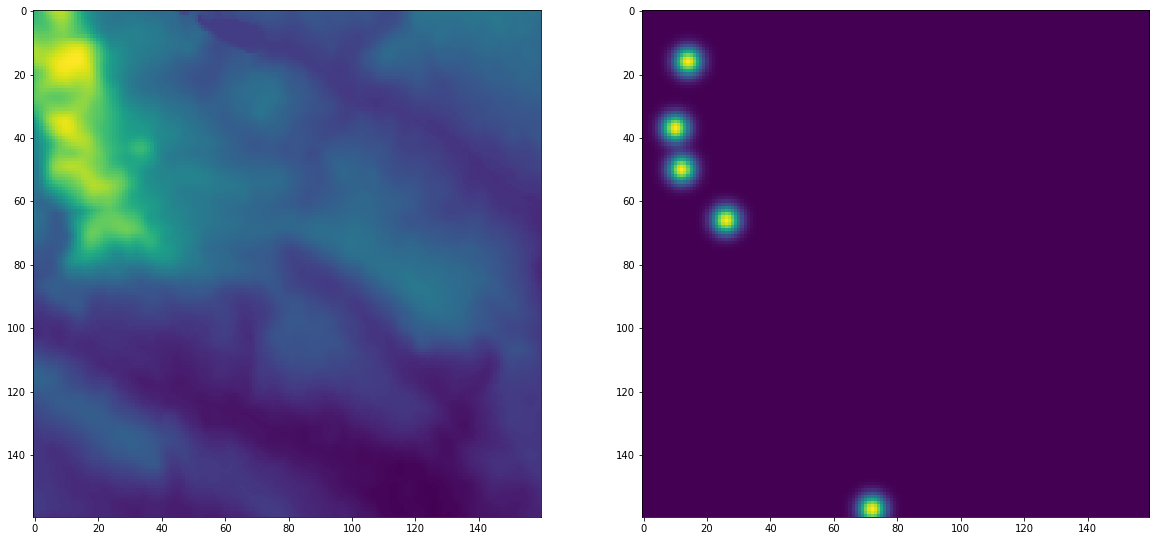

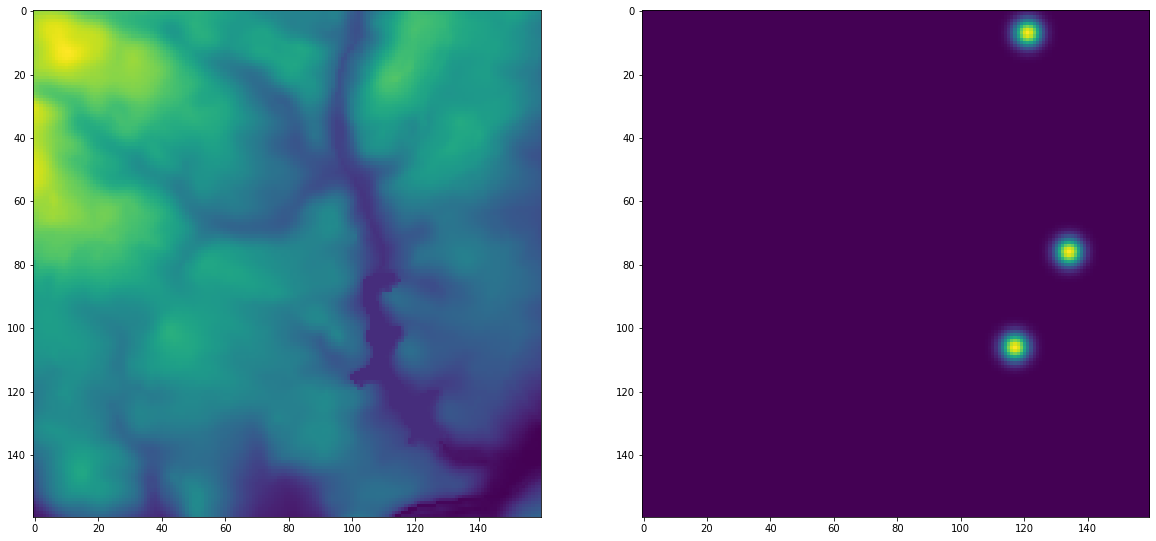

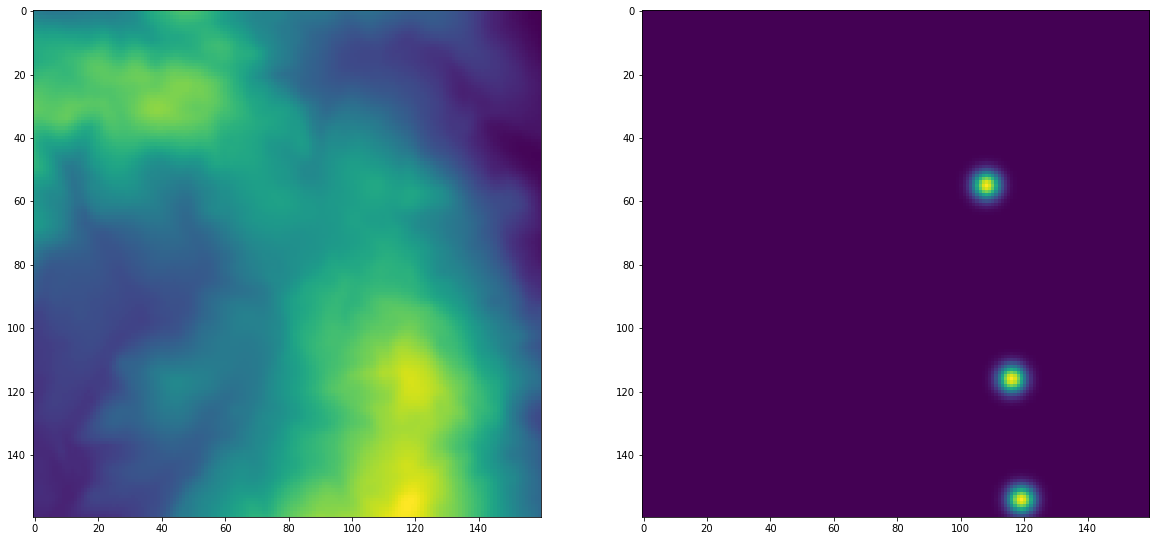

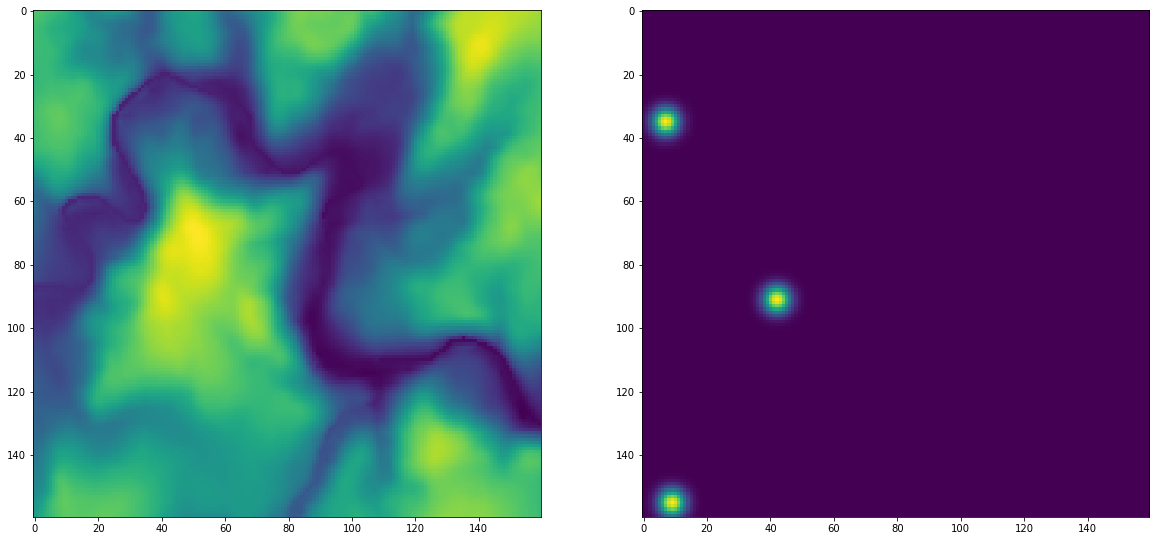

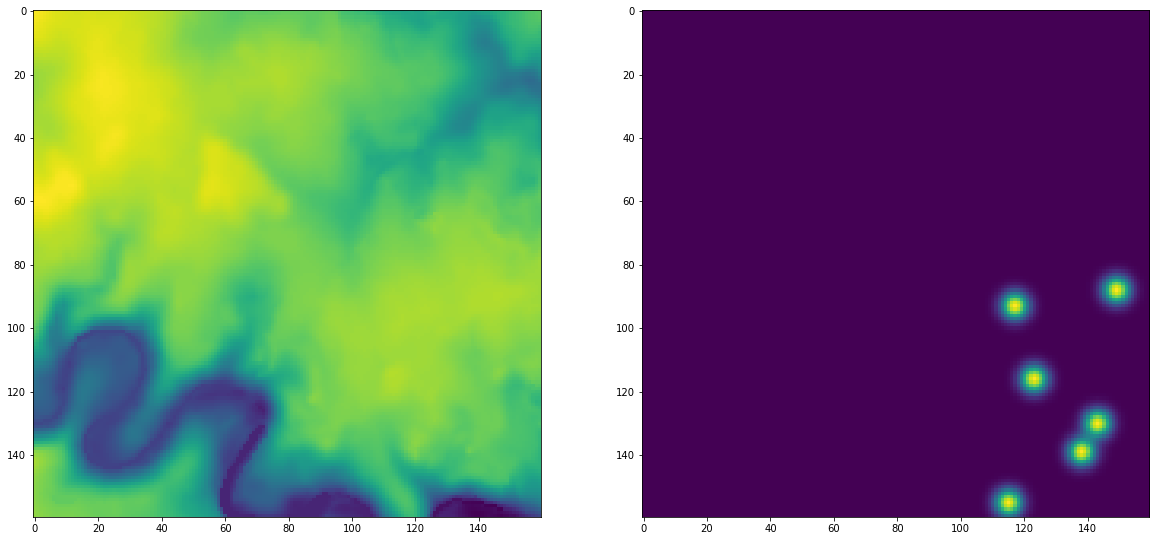

In [6]:
start = 20
counter=0
minpeaks = 3 #Minimum Number of Peaks per image
path = "./dataset_3Peaks/"
savepath = "./Presentation Pictures/"
for i in range(7, 12):
    with rasterio.open(
            path+'%d_dem.tif' %(i)) as src:
        dem = src.read(1)
    with rasterio.open(
            path+'%d_peaks.tif'%(i)) as src:
        peaks = src.read(1)
    fig = plt.figure(figsize=(20,10))
    gs = fig.add_gridspec(1,2, hspace=0)
    (ax1, ax2) = gs.subplots()
    ax1.imshow(dem[20:180, 20:180])
    ax2.imshow(peaks)
    plt.savefig(f"{savepath}dem_peak_compare_{i}.png")
    plt.show()
    